In [24]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "D:\TU_Delft_technischenatuurkunde\Master\complex networks\code\ComplexNetworks\SFHH2025.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Create an undirected graph from the dataset
G = nx.Graph()

# Add edges, ignoring time steps
edges = df[['id1', 'id2']].drop_duplicates().values.tolist()
G.add_edges_from(edges)

# 1. Number of nodes (N)
N = len(G.nodes())

# 2. Number of links (L)
L = len(G.edges())

# 3. Compute degree of each node
degrees = np.array([d for _, d in G.degree()])

# 4. Compute the average degree E[D]
E_D = np.mean(degrees)

# 5. Compute the standard deviation of the degree sqrt(Var[D])
std_D = np.std(degrees)

# Print results
print("Number of nodes (N):", N)
print("Number of links (L):", L)
print("Average degree (E[D]):", E_D)
print("Standard deviation of the degree (sqrt(Var[D])):", std_D)



<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Hp\AppData\Local\Temp\ipykernel_6928\1758305550.py:7: SyntaxWarning: invalid escape sequence '\T'
  file_path = "D:\TU_Delft_technischenatuurkunde\Master\complex networks\code\ComplexNetworks\SFHH2025.xlsx"


Number of nodes (N): 401
Number of links (L): 9415
Average degree (E[D]): 46.957605985037404
Standard deviation of the degree (sqrt(Var[D])): 29.918521078014955


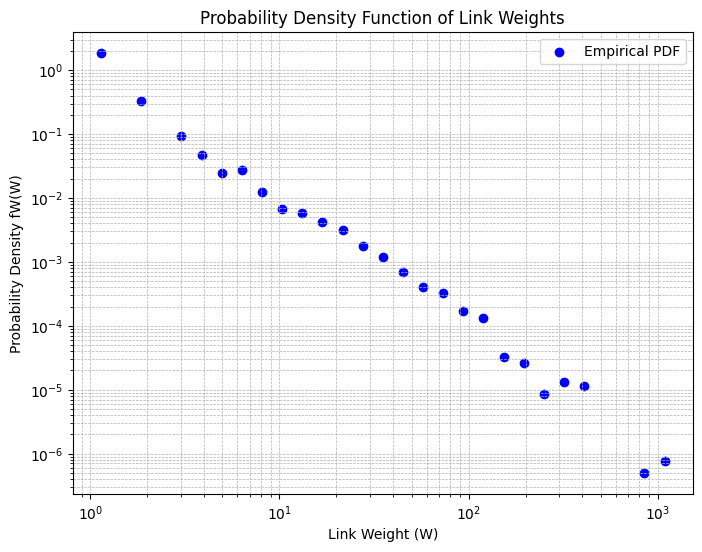

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the link weights from the dataset
weights = df.groupby(['id1', 'id2']).size().values  # Counts occurrences per (id1, id2) pair

# Define binning strategy: Use logarithmic bins for better power-law visibility
bins = np.logspace(np.log10(min(weights)), np.log10(max(weights)), num=30)

# Compute histogram
hist, bin_edges = np.histogram(weights, bins=bins, density=True)

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot PDF
plt.figure(figsize=(8,6))
plt.scatter(bin_centers, hist, marker='o', label="Empirical PDF", color="blue")

# Log-log scale for power-law analysis
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Link Weight (W)")
plt.ylabel("Probability Density fW(W)")
plt.title("Probability Density Function of Link Weights")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


Calculating best minimal value for power law fit


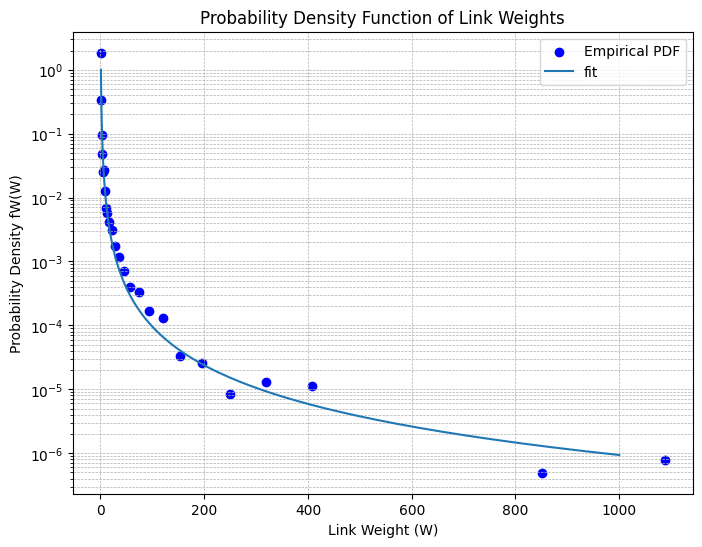

In [26]:
import powerlaw

# Fit power-law model
fit = powerlaw.Fit(weights)

# Get exponent alpha
alpha = fit.power_law.alpha

xvalues = np.logspace(0,3,100)
yvalues = xvalues**-(alpha-0.6)

plt.figure(figsize=(8,6))
plt.scatter(bin_centers, hist, marker='o', label="Empirical PDF", color="blue")
plt.plot(xvalues,yvalues, label= 'fit')

# Log-log scale for power-law analysis
# plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Link Weight (W)")
plt.ylabel("Probability Density fW(W)")
plt.title("Probability Density Function of Link Weights")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the temporal network data
# Assuming Gdata is a list of tuples (time, node_i, node_j)
Gdata = df[['id1', 'id2', 'time_step']].values.tolist()

N = G.number_of_nodes()  # Number of nodes
T = 3493  # Last time step

def simulate_spreading(seed, Gdata, T):
    infected = set([seed])
    I_t = np.zeros(T + 1)
    I_t[0] = 1  # Seed is infected at t=0

    contacts = defaultdict(list)
    for node_i, node_j, time in Gdata:
        contacts[time].append((node_i, node_j))

    for t in range(1, T + 1):
        new_infected = set()
        for node_i, node_j in contacts[t]:
            if node_i in infected and node_j not in infected:
                new_infected.add(node_j)
            elif node_j in infected and node_i not in infected:
                new_infected.add(node_i)
        infected.update(new_infected)
        I_t[t] = len(infected)

    return I_t



In [28]:
# Run simulations
all_I_t = np.zeros((N, T + 1))
for seed in range(N):
    all_I_t[seed] = simulate_spreading(seed, Gdata, T)

In [29]:
# Calculate average and standard deviation
E_I_t = np.mean(all_I_t, axis=0)
Var_I_t = np.std(all_I_t, axis=0)

print(E_I_t, Var_I_t)

[  1.           1.00498753   1.00498753 ... 397.27182045 397.27182045
 397.27182045] [ 0.          0.07044612  0.07044612 ... 20.54162926 20.54162926
 20.54162926]


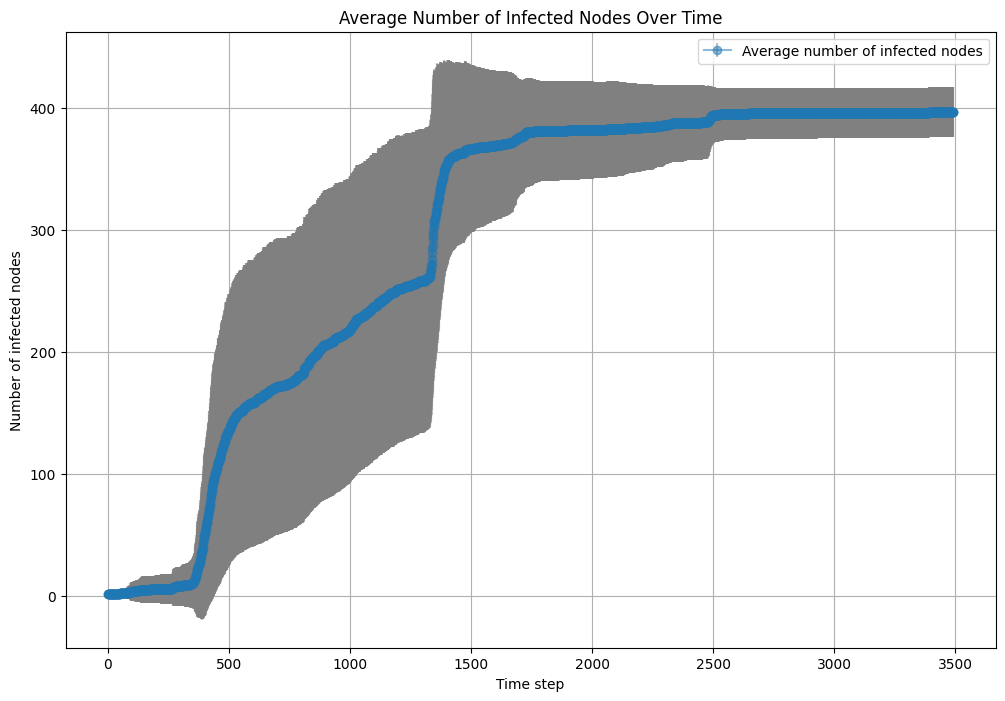

In [30]:
# Plot the average number of infected nodes with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(range(T + 1), E_I_t, yerr=Var_I_t, fmt='-o', label='Average number of infected nodes', ecolor='gray', alpha=0.5)
plt.xlabel('Time step')
plt.ylabel('Number of infected nodes')
plt.title('Average Number of Infected Nodes Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Calculate the time to infect 80% of the nodes for each seed
time_to_infect_80 = np.full(N, T + 1) 
threshold = N * 0.8 # Initialize with a value greater than T
for seed in range(N):
    I_t = simulate_spreading(seed, Gdata, T)
    if np.any(I_t >= threshold):
        time_to_infect_80[seed] = np.argmax(I_t >= threshold)

In [32]:
# Rank the nodes based on the time to infect 80% of the nodes
ranked_nodes = np.argsort(time_to_infect_80)
R = ranked_nodes + 1  # Node indices start from 1

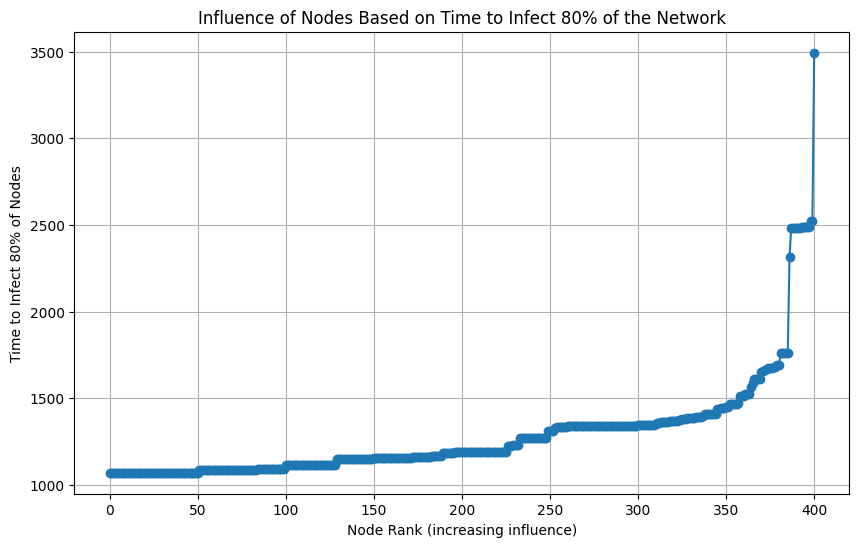

Ranking vector R: [ 17  34  35  36  40  44  43  42  46  47  48  45  49  55  52  53  65  61
  59  54  57  60  58  69  66  26  28   7   3   2  31  30  12  13  10  11
  14   6   9  19  27  20  18  25  24  23  22  21  15   8  16  76  74  73
  72  77  81  38  39  62  75  70  56  71  96  41 103 100 118 119  80 102
  68 126 101  87  99  98  95  82  78  79  67  88 130 131 104 133 108 109
 107 106 114 112 134 105 128 115 111 132 135 145  86 116 139 138 137 136
 141 142  84  85  94  93 120 110  90  89  92  91   4 127 113 123   5  83
 129 146 152 124 125 144 143  64  63 157 148 154 151 150 149 147 155 161
 163 162 166 184 168 165  50 122 117 190 192 159  51 121 140  97  29 185
 181 180 186 191 195 197 196 194 198 199 187 189 160  32  33 201 202 193
 188 164  37 182 153 178 167 158 156 179 209 208 183 200 203 205 215 204
 206 207 213 214 177 171 176 173 174 175 170 232 169 217 224 220 223 222
 221 212 218 219 216 211 231 227 172 228 225 226 233 234 210 236 241 235
 239 238 237 240 230 229 242 244 

In [33]:
# Plot the time to infect 80% of the nodes in increasing order
plt.figure(figsize=(10, 6))
plt.plot(np.sort(time_to_infect_80), marker='o')
plt.xlabel('Node Rank (increasing influence)')
plt.ylabel('Time to Infect 80% of Nodes')
plt.title('Influence of Nodes Based on Time to Infect 80% of the Network')
plt.grid(True)
plt.show()

# Print the ranking vector R
print("Ranking vector R:", R)


In [34]:
# from collections import defaultdict
# import random

# # Assuming G is the aggregated network
# degrees = dict(G.degree())
# strengths = dict(G.degree(weight='weight'))

# # Rank nodes by degree and strength
# D = sorted(degrees, key=degrees.get, reverse=True)
# S = sorted(strengths, key=strengths.get, reverse=True)
# R = ranked_nodes + 1  # Node indices start from 1

In [35]:
# def compute_recognition_rate(R, metric, f, N, iterations=1000):
#     fN = int(f * N)
#     recognition_rates = []

#     for _ in range(iterations):
#         Rf = set(random.sample(list(R[:fN]), fN))
#         metric_f = set(random.sample(list(metric[:fN]), fN))
#         recognition_rate = len(Rf.intersection(metric_f)) / fN
#         recognition_rates.append(recognition_rate)

#     return np.mean(recognition_rates)

# f_values = np.arange(0.05,0.5, 0.05)
# rRD = []
# rRS = []

# for f in f_values:
#     rRD.append(compute_recognition_rate(R, D, f, N))
#     rRS.append(compute_recognition_rate(R, S, f, N))

#     # print(rRD, rRS)

In [36]:
# plt.figure(figsize=(10, 6))
# plt.plot(f_values, rRD, label='Degree Recognition Rate', marker='o')
# plt.plot(f_values, rRS, label='Strength Recognition Rate', marker='o')
# plt.xlabel('f')
# plt.ylabel('Recognition Rate')
# plt.title('Recognition Rate vs. f')
# plt.legend()
# plt.grid(True)
# plt.show()

B10


In [37]:
# #### filepath: /home/tim/CODE/ComplexNetworks/ComplexNetworks/Notebooks/Tim_Notebook.ipynb
# # --- Code for Question 10 ---
# # 1) Build an aggregated, weighted graph from 'df' (time_step, id1, id2). 
# #    Each edge weight is the total number of contacts between two nodes.

# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx
# import random

# # Create a new weighted (aggregated) graph
# G_agg = nx.Graph()
# # Count contacts (weights) for each pair
# edge_counts = df.groupby(['id1', 'id2']).size().reset_index(name='weight')

# for _, row in edge_counts.iterrows():
#     u, v, w = row['id1'], row['id2'], row['weight']
#     G_agg.add_edge(u, v, weight=w)

# # 2) Compute degree (unweighted) and strength (weighted degree) for each node
# degree_dict = dict(G_agg.degree(weight=None))
# strength_dict = dict(G_agg.degree(weight='weight'))

# # Sort nodes by descending degree and descending strength
# D_sorted = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
# S_sorted = sorted(strength_dict.items(), key=lambda x: x[1], reverse=True)

# # Extract just the node order
# D = [node for node, deg in D_sorted]  # D(1) is highest degree
# S = [node for node, wdeg in S_sorted] # S(1) is highest strength

# print(f"D: [{' '.join(str(x) for x in D)}]")
# print(f"S: [{' '.join(str(x) for x in S)}]")
# print(f"R: [{' '.join(str(x) for x in R)}]")

# # 3) We already have R from previous steps (time to infect 80% sorted).
# #    R(1) is the most influential (fastest to infect 80%).
# #    Assume it is stored as a list of node IDs, R[0] being the top influencer.

# # 4) Define fractions to test
# fractions = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# N = G_agg.number_of_nodes()
# n_runs = 1000  # number of tie-handling runs

# def random_top_fraction(rank_list, fraction, n_runs):
#     """
#     Returns a list of sets of top-fraction nodes from 'rank_list',
#     handling any ties at the cutoff by shuffling them. Generates 'n_runs'
#     different sets.
#     """
#     import math
#     if fraction == 0:
#         return [set() for _ in range(n_runs)]
#     top_count = math.ceil(fraction * len(rank_list))
#     top_fractions = []
#     for _ in range(n_runs):
#         shuffled_list = rank_list[:]
#         random.shuffle(shuffled_list)
#         top_fractions.append(set(shuffled_list[:top_count]))
#     return top_fractions

# def recognition_rate(R, X, f, n_runs):
#     """
#     | Rf ∩ Xf | / |Rf|
#     R is seed-influence ranking, X is degree or strength ranking.
#     """
#     Rf_list = random_top_fraction(R, f, n_runs)
#     Xf_list = random_top_fraction(X, f, n_runs)
#     recognition_rates = []
#     for Rf, Xf in zip(Rf_list, Xf_list):
#         recognition_rates.append(len(Rf.intersection(Xf)) / len(Rf) if len(Rf) else 0)
#     return np.mean(recognition_rates)

# recognition_RD = []
# recognition_RS = []
# recognition_RZ = []

# for f in fractions:
#     recognition_RD.append(recognition_rate(R, D, f, n_runs))
#     recognition_RS.append(recognition_rate(R, S, f, n_runs))
#     recognition_RZ.append(recognition_rate(R, Z, f, n_runs))


In [38]:
# # 5) Plot rR_D(f) and rR_S(f) vs. f
# plt.figure(figsize=(6,4))
# plt.plot(fractions, recognition_RD, 'o-', label=r'$r_{RD}$', color='red')
# plt.plot(fractions, recognition_RS, 'o-', label=r'$r_{RS}$', color='blue')
# plt.xlabel('Fraction f')
# plt.ylabel('Recognition Rate')
# # plt.title('Top-f Recognition Rates for Degree vs Strength')
# plt.grid(True)
# plt.legend()
# plt.show()

# # 6) Interpretation:
# # The curve that stays higher indicates a better predictor of nodal influence.

In [39]:
# 2) Compute degree (unweighted) and strength (weighted degree) for each node
degree_dict = dict(G.degree(weight=None))
strength_dict = dict(G.degree(weight='weight'))

z_dict = df.groupby('id1')['time_step'].min().to_dict()

# Rank the nodes by their first contact time Z
ranked_by_first_contact = sorted(z_dict.items(), key=lambda x: x[1])

# Rank the nodes by degree
ranked_by_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# Rank the nodes by strength
ranked_by_strength = sorted(strength_dict.items(), key=lambda x: x[1], reverse=True)


# # Sort nodes by descending degree and descending strength
# D_sorted = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
# S_sorted = sorted(strength_dict.items(), key=lambda x: x[1], reverse=True)

# # Extract just the node order
# D = [node for node, deg in D_sorted]  # D(1) is highest degree
# S = [node for node, wdeg in S_sorted] # S(1) is highest strength

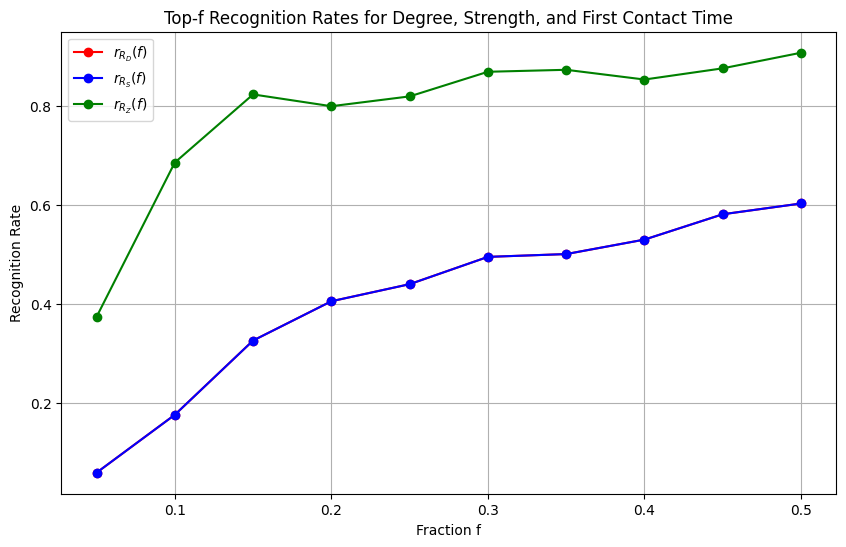

In [40]:
# # Compute degree (unweighted) and strength (weighted degree) for each node
# degree_dict = dict(G_agg.degree(weight=None))
# strength_dict = {node: sum(data['weight'] for _, _, data in G_agg.edges(node, data=True)) for node in G_agg.nodes()}
import random

# degree_dict = dict(G.degree())

# # Compute the strength of each node using the weight attribute
# strength_dict = {}
# for node in G.nodes:
#     strength_dict[node] = sum(data['weight'] for _, _, data in G.edges(node, data=True))




# Define the function to calculate recognition rates
def calculate_recognition_rates(f, iterations=1000):
    num_top_nodes = int(f * N)

    r_RD_f_degree_total = 0
    r_RS_f_strength_total = 0
    r_RZ_f_contact_total = 0

    for _ in range(iterations):
        # Shuffle the nodes to handle ties
        shuffled_nodes = np.array(list(range(N)))
        random.shuffle(shuffled_nodes)

        # Rank the nodes based on the time to infect 80% of the nodes
        ranked_nodes = np.argsort(time_to_infect_80[shuffled_nodes])
        R = shuffled_nodes[ranked_nodes]

        # Rank the nodes based on degree and strength
        D_sorted = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
        S_sorted = sorted(strength_dict.items(), key=lambda x: x[1], reverse=True)
        Z_sorted = sorted(z_dict.items(), key=lambda x: x[1])

        D = [node for node, _ in D_sorted]
        S = [node for node, _ in S_sorted]
        Z = [node for node, _ in Z_sorted]

        # Get the top f nodes by influence, degree, and strength
        top_f_influence_nodes = R[:num_top_nodes]
        top_f_degree_nodes = D[:num_top_nodes]
        top_f_strength_nodes = S[:num_top_nodes]
        top_f_contact_nodes = Z[:num_top_nodes]

        # Calculate the intersection of the top f nodes by influence and degree/strength/contact
        intersection_nodes_degree = set(top_f_influence_nodes).intersection(top_f_degree_nodes)
        intersection_nodes_strength = set(top_f_influence_nodes).intersection(top_f_strength_nodes)
        intersection_nodes_contact = set(top_f_influence_nodes).intersection(top_f_contact_nodes)

        # Calculate the recognition rate r_RD(f)/r_RS(f)/r_RZ(f) for degree/strength/contact
        r_RD_f_degree_total += len(intersection_nodes_degree) / num_top_nodes
        r_RS_f_strength_total += len(intersection_nodes_strength) / num_top_nodes
        r_RZ_f_contact_total += len(intersection_nodes_contact) / num_top_nodes

    r_RD_f_degree = r_RD_f_degree_total / iterations
    r_RS_f_strength = r_RS_f_strength_total / iterations
    r_RZ_f_contact = r_RZ_f_contact_total / iterations

    return r_RD_f_degree, r_RS_f_strength, r_RZ_f_contact

# Define the f values to test
f_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Store the results
recognition_rates = {'f': [], 'r_RD_f_degree': [], 'r_RS_f_strength': [], 'r_RZ_f_contact': []}

for f in f_values:
    r_RD_f_degree, r_RS_f_strength, r_RZ_f_contact = calculate_recognition_rates(f)
    recognition_rates['f'].append(f)
    recognition_rates['r_RD_f_degree'].append(r_RD_f_degree)
    recognition_rates['r_RS_f_strength'].append(r_RS_f_strength)
    recognition_rates['r_RZ_f_contact'].append(r_RZ_f_contact)

# Plot the recognition rates
plt.figure(figsize=(10, 6))
plt.plot(recognition_rates['f'], recognition_rates['r_RD_f_degree'], 'o-', label=r'$r_{R_D}(f)$', color='red')
plt.plot(recognition_rates['f'], recognition_rates['r_RS_f_strength'], 'o-', label=r'$r_{R_S}(f)$', color='blue')
plt.plot(recognition_rates['f'], recognition_rates['r_RZ_f_contact'], 'o-', label=r'$r_{R_Z}(f)$', color='green')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Top-f Recognition Rates for Degree, Strength, and First Contact Time')
plt.grid(True)
plt.legend()
plt.show()

hi
hi
